In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import os
from sklearn.decomposition import TruncatedSVD

In [2]:
perform_computation = True
if os.path.exists('./PCA-lib/cifar10.npz'):
    np_file = np.load('./PCA-lib/cifar10.npz')
    train_images_raw = np_file['train_images_raw']
    train_labels = np_file['train_labels']
    eval_images_raw = np_file['eval_images_raw']
    eval_labels = np_file['eval_labels']

else:
    import torchvision
    download_ = not os.path.exists('./PCA-lib/cifar10/')
    data_train = torchvision.datasets.CIFAR10('./PCA-lib/cifar10', train=True, transform=None, target_transform=None, download=download_)
    data_eval = torchvision.datasets.CIFAR10('./PCA-lib/cifar10', train=False, transform=None, target_transform=None, download=download_)
    train_images_raw = data_train.data
    train_labels = np.array(data_train.targets)
    eval_images_raw = data_eval.data
    eval_labels = np.array(data_eval.targets)
    np.savez('./PCA-lib/cifar10.npz', train_images_raw=train_images_raw, train_labels=train_labels,
             eval_images_raw=eval_images_raw, eval_labels=eval_labels)

In [3]:
images_raw = np.concatenate([train_images_raw, eval_images_raw], axis=0)
labels = np.concatenate([train_labels, eval_labels], axis=0)
images_raw.shape, labels.shape


((60000, 32, 32, 3), (60000,))

In [4]:
def set_ax_colors(ax):
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')

In [5]:
class_to_idx = {'airplane': 0,
                'automobile': 1,
                'bird': 2,
                'cat': 3,
                'deer': 4,
                'dog': 5,
                'frog': 6,
                'horse': 7,
                'ship': 8,
                'truck': 9}

In [6]:
def pca_mse(data_raw, num_components=20):

    # your code here
    N = data_raw.shape[0]
    data_raw_ = data_raw.reshape(N, -1)
    data_mean = data_raw_.mean(axis=0, dtype='float64')
    s = np.linalg.svd(data_raw_-data_mean, compute_uv=False)
    lam = (s**2) / N

    mse = lam[num_components:].sum()

    assert np.isscalar(mse)
    return np.float64(mse)

some_data = (np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20
some_mse = pca_mse(some_data, num_components=2)
assert some_mse.round(3) == 37.903

In [7]:
if perform_computation:
    class_names = []
    class_mses = []
    for cls_name, cls_label in class_to_idx.items():
        data_raw = images_raw[labels == cls_label,:,:,:]
        start_time = time.time()
        print(f'Processing Class {cls_name}', end='')
        cls_mse = pca_mse(data_raw, num_components=20)
        print(f' (The SVD operation took %.3f seconds)' % (time.time()-start_time))
        class_names.append(cls_name)
        class_mses.append(cls_mse)

Processing Class airplane (The SVD operation took 31.623 seconds)
Processing Class automobile (The SVD operation took 43.637 seconds)
Processing Class bird (The SVD operation took 32.596 seconds)
Processing Class cat (The SVD operation took 31.533 seconds)
Processing Class deer (The SVD operation took 33.572 seconds)
Processing Class dog (The SVD operation took 32.936 seconds)
Processing Class frog (The SVD operation took 32.329 seconds)
Processing Class horse (The SVD operation took 36.834 seconds)
Processing Class ship (The SVD operation took 37.645 seconds)
Processing Class truck (The SVD operation took 34.667 seconds)


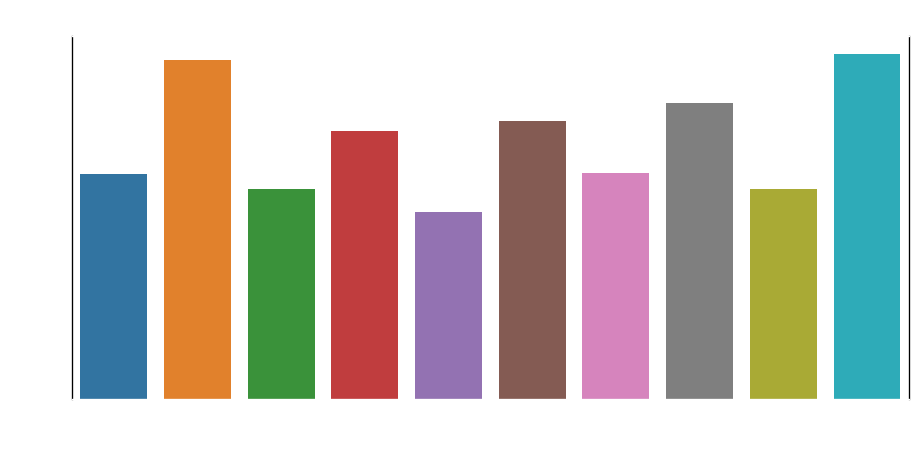

In [8]:
if perform_computation:
    fig, ax = plt.subplots(figsize=(9,4.), dpi=120)
    set_ax_colors(ax)
    sns.barplot(class_names, class_mses, ax=ax)
    ax.set_title('The Mean Squared Error of Representing Each Class by the Principal Components')
    ax.set_xlabel('Class')
    _ = ax.set_ylabel('Mean Squared Error')

In [9]:
class_mean_list = []
for cls_label in sorted(class_to_idx.values()):
    data_raw = images_raw[labels == cls_label,:,:,:]
    class_mean = np.mean(data_raw, axis=0).reshape(1,-1)
    class_mean_list.append(class_mean)
class_means = np.concatenate(class_mean_list, axis=0)

In [10]:
def mean_image_squared_distances(class_means):

    # your code here
    N, d = class_means.shape
    class_means_N1d= class_means.reshape(N, 1, d)
    class_means_1Nd = class_means.reshape(1, N, d)
    # [0,0,:] is diff of row0 - row0, [0,1,:] is diff of row0 - row1, etc
    squared_diffs_row_by_row = (class_means_N1d - class_means_1Nd)**2
    #print(squared_diffs_row_by_row)
    SquaredDistances = squared_diffs_row_by_row.sum(axis=2)

    return SquaredDistances

some_data = ((np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20) / 7.
some_dist = mean_image_squared_distances(some_data)
print(some_data@some_data.T)
assert np.array_equal(some_dist.round(3), np.array([[ 0.   ,  4.551, 18.204,  8.306, 14.041],
                                                    [ 4.551,  0.   , 12.714,  3.918, 12.551],
                                                    [18.204, 12.714,  0.   ,  8.633,  8.735],
                                                    [ 8.306,  3.918,  8.633,  0.   ,  7.49 ],
                                                    [14.041, 12.551,  8.735,  7.49 ,  0.   ]]))

[[ 9.20408163  8.73469388  7.85714286  5.55102041  2.67346939]
 [ 8.73469388 12.81632653 12.40816327  9.55102041  5.2244898 ]
 [ 7.85714286 12.40816327 24.71428571 13.14285714 13.08163265]
 [ 5.55102041  9.55102041 13.14285714 10.20408163  6.44897959]
 [ 2.67346939  5.2244898  13.08163265  6.44897959 10.18367347]]


In [34]:
def PCoA(SquaredDistances, r=2):
    assert SquaredDistances.shape[0] == SquaredDistances.shape[1]
    num_points = SquaredDistances.shape[0]

    # your code here
    N = num_points
    A = np.eye(N) - (1/N)*np.ones((N, N))
    W = (-1/2) * A @ SquaredDistances @ A.T
    #print(W)
    V, U = np.linalg.eigh(W)
    sort_args = np.argsort(-V)
    V_r = V[sort_args][0:r]**(1/2)
    U_r = U[:,sort_args[0:r]]
    VT = U_r * V_r

    assert VT.shape[0] == num_points
    assert VT.shape[1] == r
    return VT

some_data = ((np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20) / 7.
some_dist = mean_image_squared_distances(some_data)
some_pcoa = PCoA(some_dist, r=2)
assert np.array_equal(some_pcoa.round(3), np.array([[-1.974,  0.421],
                                                    [-1.285, -0.646],
                                                    [ 1.98 , -1.137],
                                                    [-0.091, -0.266],
                                                    [ 1.369,  1.628]]))

KeyboardInterrupt: 

In [12]:
if perform_computation:
    SquaredDistances = mean_image_squared_distances(class_means)
    VT = PCoA(SquaredDistances, r=2)

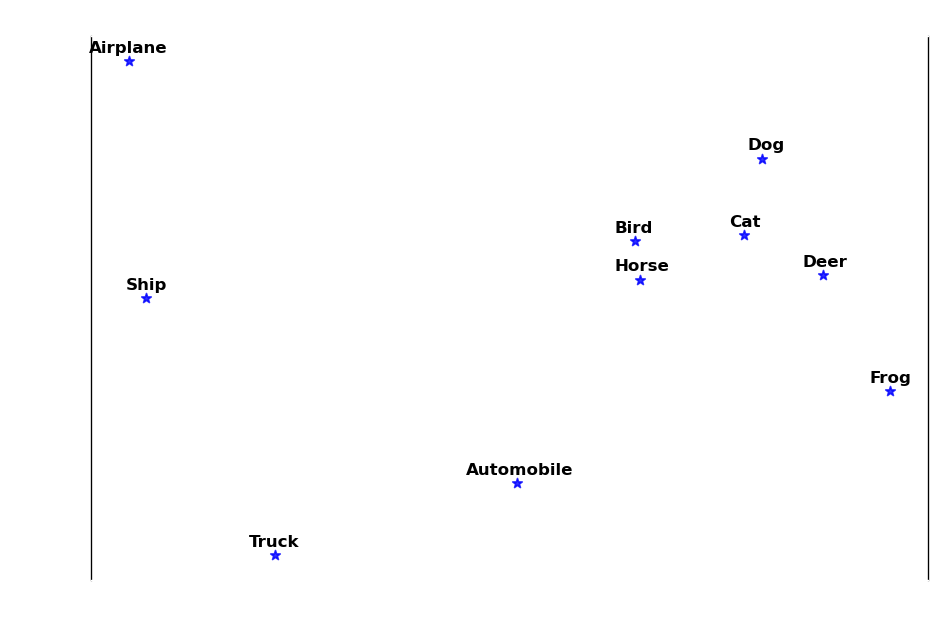

In [13]:
if perform_computation:
    class_names_list = sorted(list(class_to_idx.keys()))
    fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
    set_ax_colors(ax)
    x_components = VT[:,0]
    y_components = VT[:,1]
    sns.regplot(x=x_components, y=y_components, fit_reg=False, marker="*", color="Blue", ax=ax)
    for class_idx in range(VT.shape[0]):
        num_letters = len(class_names_list[class_idx])
        ax.text(x_components[class_idx]-num_letters*15, y_components[class_idx]+25,
                class_names_list[class_idx].capitalize(),
                horizontalalignment='left', size='medium', color='black', weight='semibold')
    ax.set_xlabel('Reconstructed Dimension 1')
    ax.set_ylabel('Reconstructed Dimension 2')
    _ = ax.set_title('PCoA on Mean CIFAR-10 Images')

In [14]:
def principal_components_precise_svd(data_raw, num_components=20):
    # your code here
    N = data_raw.shape[0]
    data_raw_ = data_raw.reshape(N, -1)
    data_mean = data_raw_.mean(axis=0, dtype='float64')
    U, S, V = np.linalg.svd(data_raw_-data_mean, compute_uv=True)

    V_x = V.T[:,:num_components]
    assert V_x.ndim==2
    # Don't mind/change the following lines.
    # This is for mitigating the ambiguity up to -/+1 factor in PCs.
    # (i.e., if x is a unitary PC, then -x is also a unitary PC).
    # We multiply each column by the sign of the largest element (in absolute value) of that column
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return V_x

some_data = (np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20
some_pcs = principal_components_precise_svd(some_data, num_components=2)
assert np.array_equal(some_pcs.round(3), np.array([[-0.123, -0.114],
                                                   [-0.43 ,  0.119],
                                                   [-0.021,  0.41 ],
                                                   [-0.603, -0.164],
                                                   [ 0.084,  0.491],
                                                   [-0.223,  0.724],
                                                   [ 0.616,  0.109]]))

In [15]:
def principal_components(data_raw, num_components=20):

    # your code here
    N = data_raw.shape[0]
    data_raw_ = data_raw.reshape(N, -1)
    data_mean = data_raw_.mean(axis=0, dtype='float64')
    svd = TruncatedSVD(n_components=num_components, n_iter=5, algorithm='randomized', random_state=12345)
    V_x = svd.fit(data_raw_-data_mean).components_.T

    assert V_x.ndim==2
    # Don't mind/change the following lines.
    # This is for mitigating the ambiguity up to -/+1 factor in PCs.
    # (i.e., if x is a unitary PC, then -x is also a unitary PC).
    # We multiply each column by the sign of the largest element (in absolute value) of that column
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return V_x

some_data = (np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20
some_pcs = principal_components(some_data, num_components=2)
assert np.array_equal(some_pcs.round(3), np.array([[-0.123, -0.114],
                                                   [-0.43 ,  0.119],
                                                   [-0.021,  0.41 ],
                                                   [-0.603, -0.164],
                                                   [ 0.084,  0.491],
                                                   [-0.223,  0.724],
                                                   [ 0.616,  0.109]]))

In [33]:
def E_A_given_B(class_A_data, class_B_data):

    # your code here
    N = class_A_data.shape[0]
    class_A_data_ = class_A_data.reshape(N, -1)
    class_A_centered = class_A_data_ - class_A_data_.mean(axis=0, dtype='float64')
    class_B_pcs = principal_components(class_B_data, num_components=20)
    r = class_B_pcs.T @ class_A_centered.T
    class_B_hat = (class_B_pcs @ r).T
    squared_diffs = (class_B_hat - class_A_centered)**2
    E_A_cond_B = np.sum(squared_diffs, axis=1).mean()

    return E_A_cond_B

some_data = ((np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20) / 7.
some_data = np.repeat(some_data, 8, axis=1)
some_E = E_A_given_B(some_data, (some_data**1.02))
assert some_E.round(3)==0.001


In [47]:
def Lingoes_PreProcessing(SimilarityMatrix):

    assert SimilarityMatrix.shape[0] == SimilarityMatrix.shape[1]
    num_points = SimilarityMatrix.shape[0]

    # your code here
    N = num_points
    A = np.eye(N) - (1/N)*np.ones((N, N))
    W = (-1/2) * A @ SimilarityMatrix @ A.T
    #print(W)
    V, _ = np.linalg.eigh(W)
    V_min = np.min(V)

    if V_min >= 0:
        return SimilarityMatrix

    ProcessedSimilarityMatrix = SimilarityMatrix + ( (np.eye(N) - 1) * - (np.abs(V_min)*2) )

    return ProcessedSimilarityMatrix

some_data = ((np.arange(35, dtype='int64').reshape(5,7) ** 13) % 20) / 7.
some_dist = mean_image_squared_distances(some_data)**5.
some_lingoes = Lingoes_PreProcessing(some_dist)
assert np.array_equal(some_lingoes.round(1), np.array([[      0. ,  898987.1, 2896177.9,  936570.7, 1442744.7],
                                                       [ 898987.1,       0. , 1229280.9,  897958.5, 1208489.7],
                                                       [2896177.9, 1229280.9,       0. ,  944977.4,  947878.7],
                                                       [ 936570.7,  897958.5,  944977.4,       0. ,  920604.3],
                                                       [1442744.7, 1208489.7,  947878.7,  920604.3,       0. ]]))